<a href="https://colab.research.google.com/github/VStee1e/EEG-Location-Prediction/blob/main/Shift_Invariant_k_means_with_CUE_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [22]:
!pip install mne
!pip install BOWaves
import mne
import numpy as np
import scipy.io as sio
import os
import fnmatch
# import numpy as np
# import mne
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
from BOWaves.sikmeans import sikmeans_core
from BOWaves.utilities.wrappers import si_pairwise_distances_argmin_min
from BOWaves.utilities.wrappers import si_pairwise_distances_argmin_min_scipyvq

from scipy.signal import fftconvolve
from scipy.cluster import vq
import numbers


Load data

In [58]:
sig_fn_1 = 'cue_subj_01_chunked.npz'
fl = 12
sfreq = 512
n_components = 63
sig_fns = [sig_fn_1]
dm_lis = []
mm_lis = []
N_ = []
for i in range(fl):
    fn = 'icaweights0' + str(i+1) + '.mat'
    dm_lis.append(fn)
for i in range(fl):
    fn = 'icawinv0' + str(i+1) + '.mat'
    mm_lis.append(fn)
dm1, dm2, dm3, dm4, dm5, dm6, dm7, dm8, dm9, dm10, dm11, dm12 = dm_lis
mm1, mm2, mm3, mm4, mm5, mm6, mm7, mm8, mm9, mm10, mm11, mm12 = mm_lis
for i in range(len(dm_lis)):
    dm_lis[i] = sio.loadmat(dm_lis[i])
    mm_lis[i] = sio.loadmat(mm_lis[i])
for i in range(len(dm_lis)):
    # Access the arrays within the dictionaries using the appropriate keys
    # Assuming 'icaweights' and 'icawinv' are the keys for the arrays in the .mat files
    N_.append(np.concatenate((dm_lis[i]['icaweights'][1,:], mm_lis[i]['icawinv'][:,1])))

-0.06793365240134176

Create topo maps

IndexError: tuple index out of range

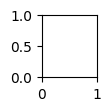

In [37]:
info = mne.create_info(64, sfreq, ch_types='eeg')

# Get the channel names from the biosemi256 montage
biosemi256_montage = mne.channels.make_standard_montage('biosemi128')
biosemi256_channel_names = biosemi256_montage.ch_names

# Select the first 63 channel names to match your data
relevant_channel_names = biosemi256_channel_names[:64]

# Rename the channels in your info object
mapping = {str(i): name for i, name in enumerate(relevant_channel_names)}
info.rename_channels(mapping)

# Now you can set the montage
info.set_montage('biosemi128')
for j in range(n_components):
    mne.viz.plot_topomap(N_[0][j], info)

Grab Windows

In [23]:
def check_rng(seed):
    """Turn seed into a np.random.Generator instance

    Parameters
    ----------
    seed : None, int or instance of Generator
        If seed is None, return the Generator using the OS entropy.
        If seed is an int, return a new Generator instance seeded with seed.
        If seed is already a Generator instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None:
        return np.random.default_rng()
    if isinstance(seed, numbers.Integral):
        seed = np.random.SeedSequence(seed)
        return np.random.default_rng(seed)
    if isinstance(seed, np.random.Generator):
        return seed

    raise ValueError('%r cannot be used to seed a numpy.random.Generator'
                     ' instance' % seed)

def pick_random_windows(X, n_windows, window_length, rng=None):
    """
    It picks windows randomly from each row of `X`.

    Parameters
    ----------
    X (numpy.ndarray):
        Matrix with data samples in its rows.
    n_windows (int):
        Number of unique windows per sample. Windows are taken randomly, but
        each window is different.
    window_length (int):
        Lenght of the window
    rng (int, Generator instance, or None):
        Determines random number generation for picking the windows. Use an
        int to make the randomness deterministic.

    Returns
    -------
    Y (numpy.ndarray):
        Windows of rows of `X` selected randomly

    Shapes
    ------
    X : (`n_samples`, `n_features`)
    Y : (`n_samples`, `n_windows`, `window_length`)
    """

    if X.ndim == 1:
        X = X[np.newaxis, :]

    n_samples, n_features = X.shape
    n_bytes_per_element = X.dtype.itemsize
    n_offsets = n_features - window_length + 1
    peak_memory_use = n_samples * n_offsets * window_length \
                      * n_bytes_per_element

    rng = check_rng(rng)

In [51]:
from BOWaves.utilities.sikmeans_utils import pick_random_windows as prw

In [82]:
# pick_random_windows(S_,2000,2)
windows = []
for i, filename in enumerate(sig_fns):
  time_ser = np.load(filename, allow_pickle=True)['icaact'][0]
  print(time_ser.shape)
  for k in range(n_components):
    win = prw(time_ser, 25, 2, None)

si_pairwise_distances_argmin_min_scipyvq(win, 400, 'cosine', np.linalg.norm(win, axis=1))


(63, 7680)


AttributeError: 'int' object has no attribute 'ndim'

In [87]:
# Calculate centroids (example using k-means)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=34, random_state=0, n_init='auto').fit(win.reshape(win.shape[0], -1))
centroids = kmeans.cluster_centers_

# Call the function with the calculated centroids
si_pairwise_distances_argmin_min_scipyvq(win_reshaped, centroids, 'cosine', np.linalg.norm(win, axis=(1,2)))

(array([11, 31,  9, 29,  7,  5, 32,  4, 33,  4, 30, 26,  1, 30, 17,  6, 18,
        22,  1, 22, 20,  9,  1, 16, 13,  2,  8, 15, 15,  0,  3,  2,  6,  3,
        25, 16, 12, 22, 14,  5, 29, 22, 24,  3,  0,  1, 19, 26,  4, 21, 10,
         1, 21, 30, 22, 22, 30, 27, 22, 28, 13,  9, 23]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.03915186e+00, 1.49011612e-08, 0.00000000e+00,
        1.49011612e-08, 1.01717692e+00, 9.88432599e-01, 1.02046716e+00,
        7.71184398e-01, 1.09848632e+00, 0.00000000e+00, 1.07506195e+00,
        0.00000000e+00, 9.35888568e-01, 8.40405275e-01, 1.09005226e+00,
        0.00000000e+00, 1.14646562e+00, 8.86001348e-01, 0.00000000e+00,
        1.16214971e+00, 1.08187469e+00, 0.00000000e+00, 1.02257710e

In [86]:
win.shape
win_reshaped = win.reshape(win.shape[0], -1)
win_reshaped.shape

(63, 50)